<h1 style="text-align:center; color:#4CAF50;">
Fraud Detection Project  
</h1>

<h3 style="text-align:center; color:#555;">
Using Machine Learning for Transaction Fraud Identification  
</h3>

<hr>

<div style="background-color:#dbeafe; padding:20px; border-radius:10px; text-align:center; font-size:28px; font-weight:bold;">
Import Libraries
</div>


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

import joblib
import pickle


<div style="background-color:#dbeafe; padding:20px; border-radius:10px; text-align:center; font-size:28px; font-weight:bold;">
🔍 Exploratory Data Analysis (EDA)
</div>

In [2]:
df = pd.read_csv("synthetic_fraud_dataset.csv")


In [3]:
df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1


In [4]:
print("Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nDuplicates:", df.duplicated().sum())

Shape: (50000, 21)

Data Types:
 Transaction_ID                   object
User_ID                          object
Transaction_Amount              float64
Transaction_Type                 object
Timestamp                        object
Account_Balance                 float64
Device_Type                      object
Location                         object
Merchant_Category                object
IP_Address_Flag                   int64
Previous_Fraudulent_Activity      int64
Daily_Transaction_Count           int64
Avg_Transaction_Amount_7d       float64
Failed_Transaction_Count_7d       int64
Card_Type                        object
Card_Age                          int64
Transaction_Distance            float64
Authentication_Method            object
Risk_Score                      float64
Is_Weekend                        int64
Fraud_Label                       int64
dtype: object

Missing Values:
 Transaction_ID                  0
User_ID                         0
Transaction_Amount         

In [5]:
print("\nSummary Statistics:\n", df.describe(include="all"))


Summary Statistics:
        Transaction_ID    User_ID  Transaction_Amount Transaction_Type  \
count           50000      50000        50000.000000            50000   
unique          50000       8963                 NaN                4   
top         TXN_33553  USER_6599                 NaN              POS   
freq                1         16                 NaN            12549   
mean              NaN        NaN           99.411012              NaN   
std               NaN        NaN           98.687292              NaN   
min               NaN        NaN            0.000000              NaN   
25%               NaN        NaN           28.677500              NaN   
50%               NaN        NaN           69.660000              NaN   
75%               NaN        NaN          138.852500              NaN   
max               NaN        NaN         1174.140000              NaN   

                  Timestamp  Account_Balance Device_Type Location  \
count                 50000     

<div style="background-color:#dbeafe; padding:20px; border-radius:10px; text-align:center; font-size:28px; font-weight:bold;">
Data Visualization
</div>

In [6]:

sns.set_theme(style="darkgrid")
palette_main = ["#00D1FF", "#FF3860", "#7C3AED", "#00E676", "#FDD835"]

c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


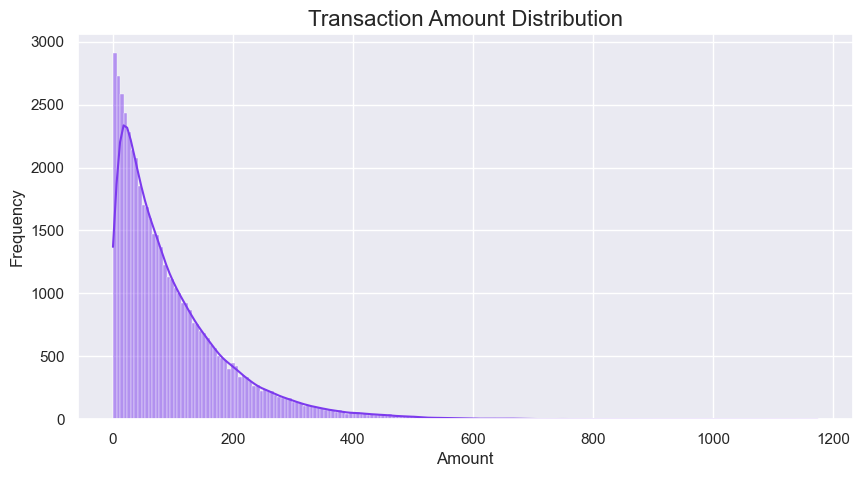

In [7]:
plt.figure(figsize=(10,5))
sns.histplot(df["Transaction_Amount"], kde=True, color="#7C3AED")
plt.title("Transaction Amount Distribution", fontsize=16)
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

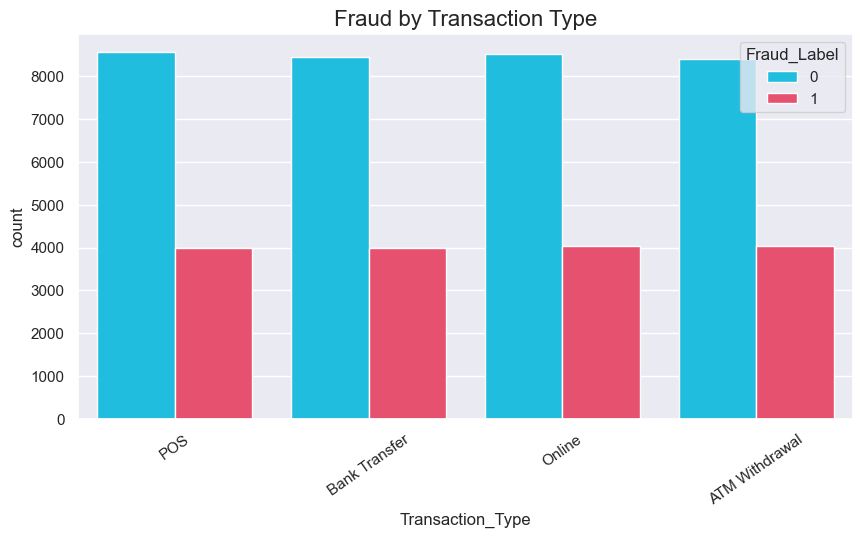

In [10]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="Transaction_Type", hue="Fraud_Label", palette=["#00D1FF", "#FF3860"])
plt.title("Fraud by Transaction Type", fontsize=16)
plt.xticks(rotation=35)
plt.show()

c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

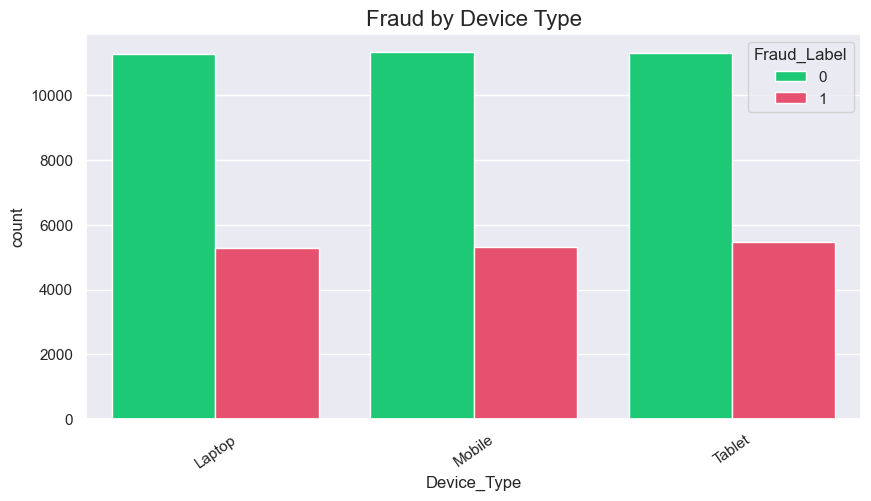

In [11]:

plt.figure(figsize=(10,5))
sns.countplot(data=df, x="Device_Type", hue="Fraud_Label", palette=["#00E676", "#FF3860"])
plt.title("Fraud by Device Type", fontsize=16)
plt.xticks(rotation=35)
plt.show()


c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

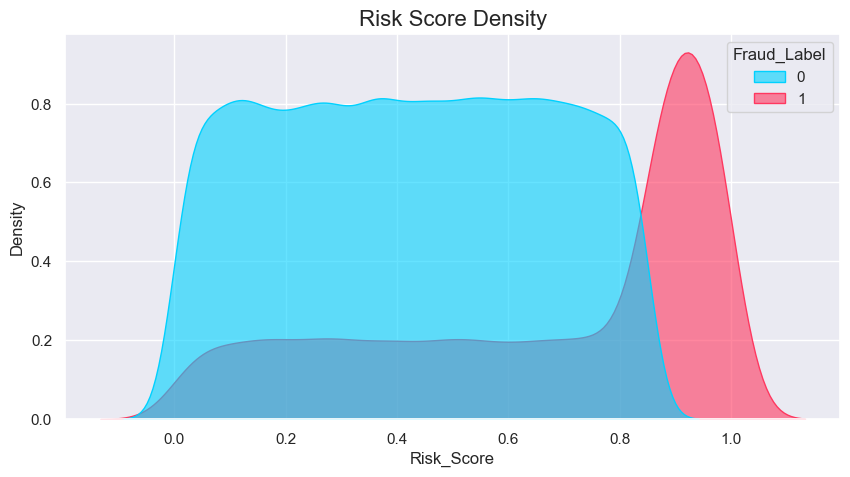

In [12]:
plt.figure(figsize=(10,5))
sns.kdeplot(data=df, x="Risk_Score", hue="Fraud_Label", fill=True, alpha=0.6, palette=["#00D1FF","#FF3860"])
plt.title("Risk Score Density", fontsize=16)
plt.show()

c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


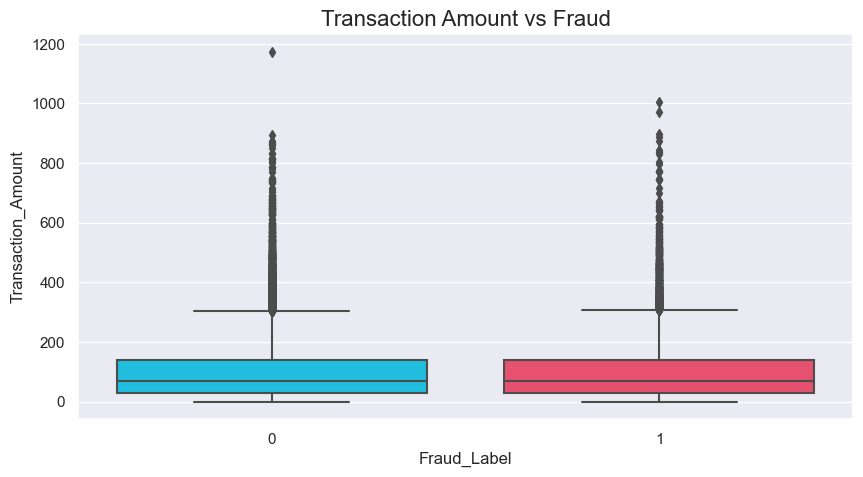

In [13]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x="Fraud_Label", y="Transaction_Amount", palette=["#00D1FF", "#FF3860"])
plt.title("Transaction Amount vs Fraud", fontsize=16)
plt.show()

c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

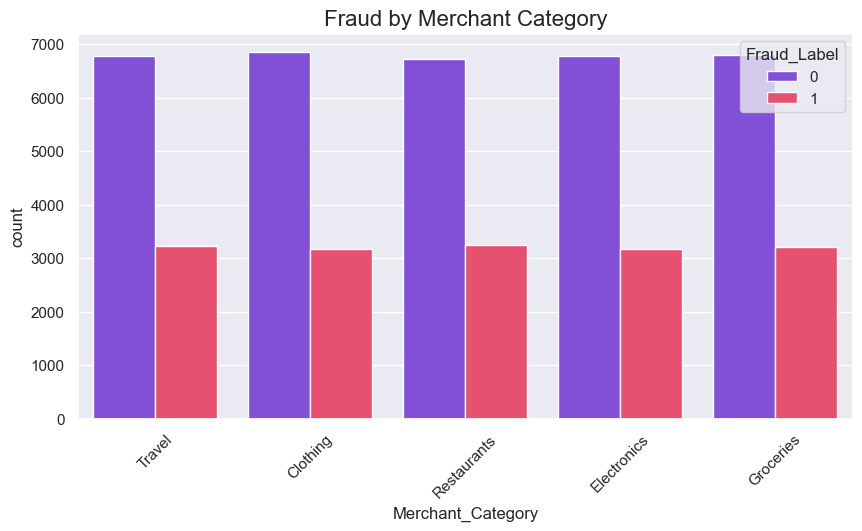

In [15]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="Merchant_Category", hue="Fraud_Label", palette=["#7C3AED","#FF3860"])
plt.title("Fraud by Merchant Category", fontsize=16)
plt.xticks(rotation=45)
plt.show()

c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categor

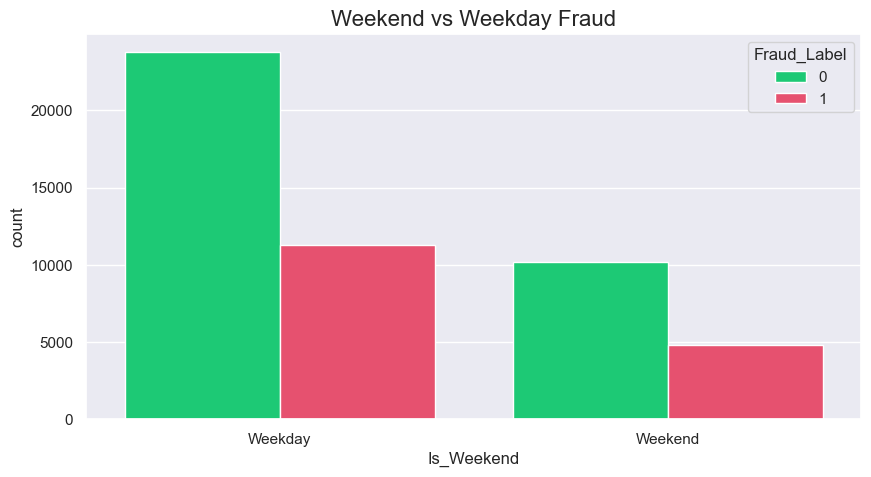

In [16]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="Is_Weekend", hue="Fraud_Label", palette=["#00E676", "#FF3860"])
plt.title("Weekend vs Weekday Fraud", fontsize=16)
plt.xticks([0,1], ["Weekday","Weekend"])
plt.show()

<div style="background-color:#dbeafe; padding:20px; border-radius:10px; text-align:center; font-size:28px; font-weight:bold;">
🛠️ Feature Engineering
</div>


In [21]:
df.columns

Index(['Transaction_ID', 'User_ID', 'Transaction_Amount', 'Transaction_Type',
       'Timestamp', 'Account_Balance', 'Device_Type', 'Location',
       'Merchant_Category', 'IP_Address_Flag', 'Previous_Fraudulent_Activity',
       'Daily_Transaction_Count', 'Avg_Transaction_Amount_7d',
       'Failed_Transaction_Count_7d', 'Card_Type', 'Card_Age',
       'Transaction_Distance', 'Authentication_Method', 'Risk_Score',
       'Is_Weekend', 'Fraud_Label'],
      dtype='object')

c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


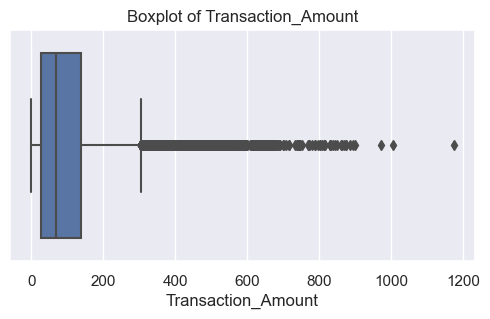

c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


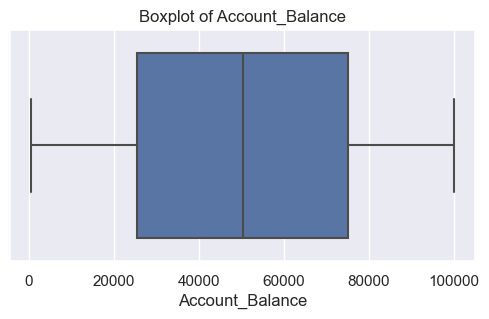

c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


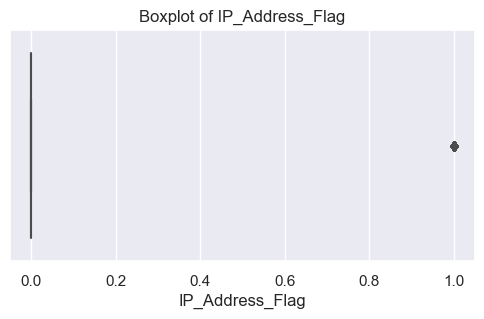

c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


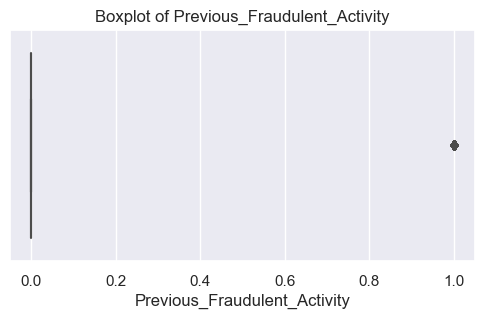

c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


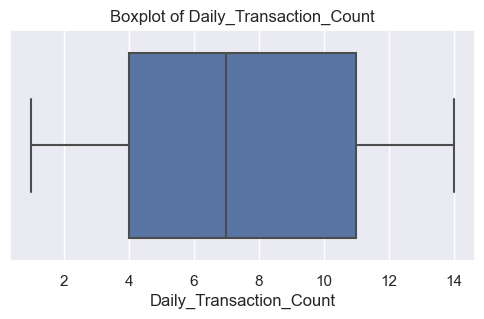

c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


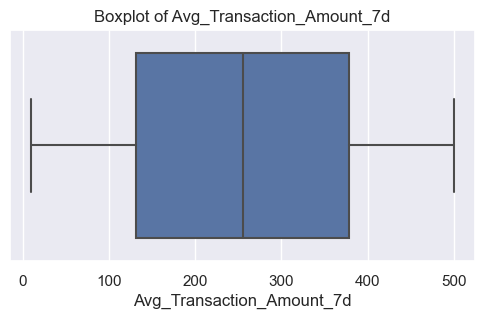

c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


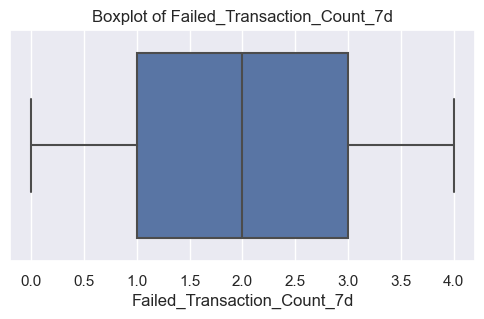

c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


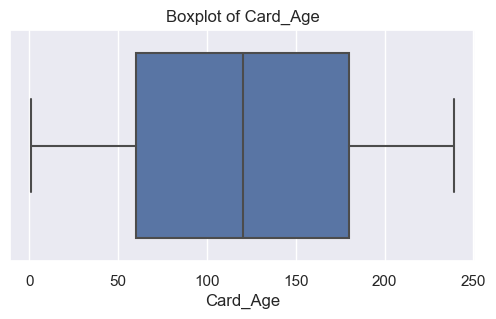

c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


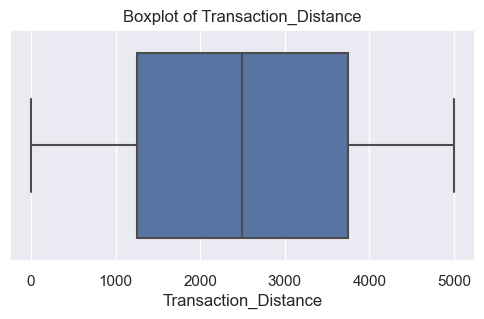

c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


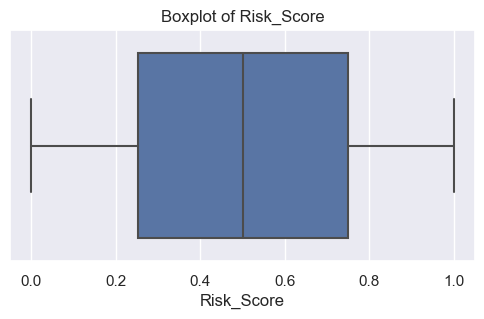

c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


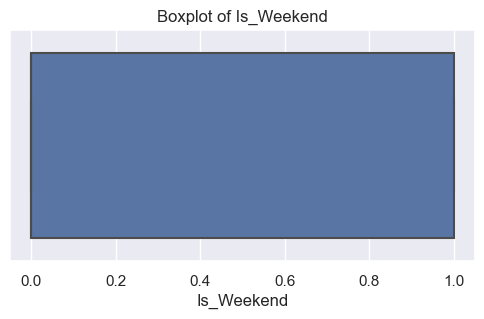

c:\Users\DELL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


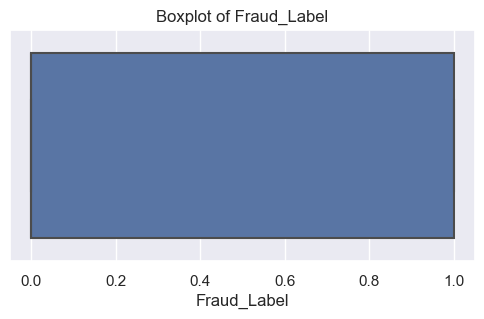

In [22]:
# Boxplots for outliers
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

In [8]:
df = pd.read_csv("synthetic_fraud_dataset.csv")
df

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,TXN_11284,USER_4796,45.05,Online,2023-01-29 18:38:00,76960.11,Mobile,Tokyo,Clothing,0,...,2,389.00,3,Amex,98,1537.54,PIN,0.1493,1,0
49996,TXN_44732,USER_1171,126.15,POS,2023-05-09 08:55:00,28791.75,Mobile,Tokyo,Clothing,0,...,13,434.95,4,Visa,93,2555.72,Biometric,0.3653,0,1
49997,TXN_38158,USER_2510,72.02,Online,2023-01-30 19:32:00,29916.41,Laptop,Mumbai,Clothing,0,...,1,369.15,2,Visa,114,4686.59,Biometric,0.5195,0,0
49998,TXN_860,USER_2248,64.89,Bank Transfer,2023-03-09 19:47:00,67895.67,Mobile,Tokyo,Electronics,0,...,13,242.29,4,Discover,72,4886.92,Biometric,0.7063,0,1


In [9]:
df = df.drop_duplicates()
df

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,TXN_11284,USER_4796,45.05,Online,2023-01-29 18:38:00,76960.11,Mobile,Tokyo,Clothing,0,...,2,389.00,3,Amex,98,1537.54,PIN,0.1493,1,0
49996,TXN_44732,USER_1171,126.15,POS,2023-05-09 08:55:00,28791.75,Mobile,Tokyo,Clothing,0,...,13,434.95,4,Visa,93,2555.72,Biometric,0.3653,0,1
49997,TXN_38158,USER_2510,72.02,Online,2023-01-30 19:32:00,29916.41,Laptop,Mumbai,Clothing,0,...,1,369.15,2,Visa,114,4686.59,Biometric,0.5195,0,0
49998,TXN_860,USER_2248,64.89,Bank Transfer,2023-03-09 19:47:00,67895.67,Mobile,Tokyo,Electronics,0,...,13,242.29,4,Discover,72,4886.92,Biometric,0.7063,0,1


In [10]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df

,transaction_id,user_id,transaction_amount,transaction_type,timestamp,account_balance,device_type,location,merchant_category,ip_address_flag,...,daily_transaction_count,avg_transaction_amount_7d,failed_transaction_count_7d,card_type,card_age,transaction_distance,authentication_method,risk_score,is_weekend,fraud_label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,TXN_11284,USER_4796,45.05,Online,2023-01-29 18:38:00,76960.11,Mobile,Tokyo,Clothing,0,...,2,389.00,3,Amex,98,1537.54,PIN,0.1493,1,0
49996,TXN_44732,USER_1171,126.15,POS,2023-05-09 08:55:00,28791.75,Mobile,Tokyo,Clothing,0,...,13,434.95,4,Visa,93,2555.72,Biometric,0.3653,0,1
49997,TXN_38158,USER_2510,72.02,Online,2023-01-30 19:32:00,29916.41,Laptop,Mumbai,Clothing,0,...,1,369.15,2,Visa,114,4686.59,Biometric,0.5195,0,0
49998,TXN_860,USER_2248,64.89,Bank Transfer,2023-03-09 19:47:00,67895.67,Mobile,Tokyo,Electronics,0,...,13,242.29,4,Discover,72,4886.92,Biometric,0.7063,0,1


In [12]:
for col in df.select_dtypes(include=['float64','int64']).columns:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df = df[(df[col] >= lower) & (df[col] <= upper)]

print("Shape after cleaning:", df.shape)

Shape after cleaning: (39468, 21)


In [13]:
cols_to_drop = [
    'risk_score',
    'previous_fraudulent_activity',
    'daily_transaction_count',
    'avg_transaction_amount_7d'
]

X = df.drop(['fraud_label'] + cols_to_drop, axis=1)
y = df['fraud_label']


In [14]:
df= df.drop(columns=[ 'risk_score', 'previous_fraudulent_activity', 'ip_address_flag'])


In [15]:
df.to_csv("cleaned_fraud_dataset.csv", index=False)
print("Cleaned dataset saved as cleaned_fraud_dataset.csv")

Cleaned dataset saved as cleaned_fraud_dataset.csv


In [16]:

categorical_cols = [
    "transaction_type",
    "device_type",
    "location",
    "merchant_category",
    "card_type",
    "authentication_method"
]

encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

df = df.drop(["transaction_id", "user_id"], axis=1)

print(df.head())


   transaction_amount  transaction_type            timestamp  account_balance  \
0               39.79                 3  2023-08-14 19:30:00         93213.17   
3              254.32                 0  2023-12-07 00:31:00         76807.20   
4               31.28                 3  2023-11-11 23:44:00         92354.66   
5              168.55                 2  2023-06-05 20:55:00         33236.94   
6                3.79                 3  2023-11-07 01:18:00         86834.18   

   device_type  location  merchant_category  daily_transaction_count  \
0            0         3                  4                        7   
3            2         2                  0                        8   
4            1         1                  1                       14   
5            0         4                  3                        3   
6            2         0                  3                        2   

   avg_transaction_amount_7d  failed_transaction_count_7d  card_type  \
0       

In [17]:
df.head()

,transaction_amount,transaction_type,timestamp,account_balance,device_type,location,merchant_category,daily_transaction_count,avg_transaction_amount_7d,failed_transaction_count_7d,card_type,card_age,transaction_distance,authentication_method,is_weekend,fraud_label
0,39.79,3,2023-08-14 19:30:00,93213.17,0,3,4,7,437.63,3,0,65,883.17,0,0,0
3,254.32,0,2023-12-07 00:31:00,76807.20,2,2,0,8,182.48,4,3,76,1311.86,1,0,1
4,31.28,3,2023-11-11 23:44:00,92354.66,1,1,1,14,328.69,4,2,140,966.98,3,1,1
5,168.55,2,2023-06-05 20:55:00,33236.94,0,4,3,3,226.85,2,1,51,1725.64,1,0,0
6,3.79,3,2023-11-07 01:18:00,86834.18,2,0,3,2,298.35,2,2,168,3757.19,3,0,0


In [18]:
print(df.columns.tolist())


['transaction_amount', 'transaction_type', 'timestamp', 'account_balance', 'device_type', 'location', 'merchant_category', 'daily_transaction_count', 'avg_transaction_amount_7d', 'failed_transaction_count_7d', 'card_type', 'card_age', 'transaction_distance', 'authentication_method', 'is_weekend', 'fraud_label']


In [19]:
print("X shape:", X.shape)
print("X columns:", list(X.columns))


X shape: (39468, 16)
X columns: ['transaction_id', 'user_id', 'transaction_amount', 'transaction_type', 'timestamp', 'account_balance', 'device_type', 'location', 'merchant_category', 'ip_address_flag', 'failed_transaction_count_7d', 'card_type', 'card_age', 'transaction_distance', 'authentication_method', 'is_weekend']


In [20]:
df.to_csv("D:/DEPI/Graduation/Fraud detection/Final_dataset.csv", index=False)

In [21]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

df['hour'] = df['timestamp'].dt.hour          
df['day'] = df['timestamp'].dt.day           
df['month'] = df['timestamp'].dt.month        
df['day_of_week'] = df['timestamp'].dt.dayofweek 

df = df.drop('timestamp', axis=1)


In [24]:
X = df.drop(columns=['fraud_label'])
y = df['fraud_label']


In [25]:
X.head()

,transaction_amount,transaction_type,account_balance,device_type,location,merchant_category,daily_transaction_count,avg_transaction_amount_7d,failed_transaction_count_7d,card_type,card_age,transaction_distance,authentication_method,is_weekend,hour,day,month,day_of_week
0,39.79,3,93213.17,0,3,4,7,437.63,3,0,65,883.17,0,0,19,14,8,0
3,254.32,0,76807.20,2,2,0,8,182.48,4,3,76,1311.86,1,0,0,7,12,3
4,31.28,3,92354.66,1,1,1,14,328.69,4,2,140,966.98,3,1,23,11,11,5
5,168.55,2,33236.94,0,4,3,3,226.85,2,1,51,1725.64,1,0,20,5,6,0
6,3.79,3,86834.18,2,0,3,2,298.35,2,2,168,3757.19,3,0,1,7,11,1


In [26]:
unique_summary = {
    "Column": [],
    "Unique_Count": [],
    "Unique_Values": []
}

for col in X.columns:
    unique_summary["Column"].append(col)
    unique_summary["Unique_Count"].append(df[col].nunique())
    unique_summary["Unique_Values"].append(df[col].unique())

unique_df = pd.DataFrame(unique_summary)
print(unique_df)


                         Column  Unique_Count  \
0            transaction_amount         18945   
1              transaction_type             4   
2               account_balance         39378   
3                   device_type             3   
4                      location             5   
5             merchant_category             5   
6       daily_transaction_count            14   
7     avg_transaction_amount_7d         26840   
8   failed_transaction_count_7d             5   
9                     card_type             4   
10                     card_age           231   
11         transaction_distance         37845   
12        authentication_method             4   
13                   is_weekend             2   
14                         hour            24   
15                          day            31   
16                        month            12   
17                  day_of_week             7   

                                        Unique_Values  
0   [39.79, 

In [27]:
y.head()

0    0
3    1
4    1
5    0
6    0
Name: fraud_label, dtype: int64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [29]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)


In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


<div style="background-color:#dbeafe; padding:20px; border-radius:10px; text-align:center; font-size:28px; font-weight:bold;">
🤖 Model Training
</div>

## Random Forrest

In [31]:

model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',
    max_depth=12
)

model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=200,
                       random_state=42)

In [32]:
y_pred = model.predict(X_test)


In [33]:
print(confusion_matrix(y_test, y_pred))


[[5447    0]
 [ 853 1594]]


In [34]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      1.00      0.93      5447
           1       1.00      0.65      0.79      2447

    accuracy                           0.89      7894
   macro avg       0.93      0.83      0.86      7894
weighted avg       0.91      0.89      0.88      7894



In [35]:
print("ROC-AUC:", roc_auc_score(y_test, y_pred))


ROC-AUC: 0.8257049448304046


In [36]:
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

Training Accuracy: 0.8342741750424526


In [37]:
accuracy_score(y_test, y_pred)

0.8919432480364834

In [40]:
with open("fraud_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Model saved as fraud_model.pkl")

✅ Model saved as fraud_model.pkl


## XGBoost

In [ ]:
model = XGBClassifier(
    n_estimators=300,        
    learning_rate=0.05,      
    max_depth=6,             
    subsample=0.8,         
    colsample_bytree=0.8,    
    random_state=42,
    scale_pos_weight=1      
)


In [43]:
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [44]:
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]


In [45]:
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("Testing Accuracy:", accuracy_score(y_test, y_pred))


Training Accuracy: 0.8844475721323012
Testing Accuracy: 0.8856113487953163


In [46]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92      6075
           1       1.00      0.64      0.78      2807

    accuracy                           0.89      8882
   macro avg       0.93      0.82      0.85      8882
weighted avg       0.90      0.89      0.88      8882

ROC-AUC: 0.8239853921926519
